<a href="https://colab.research.google.com/github/ThiagoMartinsThome/TFM/blob/master/ConvLSTM2D_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector
from tensorflow.keras.layers import Activation, MaxPool3D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import joblib
rcParams['figure.figsize'] = 16, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load and prepare the data

#### Load the data

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TFM/tradebot_tfm/data_20day_chg_target.zip', parse_dates=['date'])

# load data
data = df.copy()
data.drop('long_name', axis=1, inplace=True)
data.dropna(inplace=True, axis=0)
data.sort_values(by=['ticker', 'date'], ascending=True, inplace=True)
data.set_index('date', inplace=True)

print('Null values: ', data.isnull().sum().sum())

data.head()

Null values:  0


,ticker,open,high,low,close,volume,sp_open,sp_high,sp_low,sp_close,sp_volume,sp_percent_change,percent_change,relative_change,year,month,day,day_of_year,week_of_year,quarter,f_14_period_rsi,f_14_period_stoch_k,f_20_period_cci,up_move,down_move,plus,minus,f_14_period_adx,diplus,diminus,ao,mom,macd,signal_x,f_14_period_stochastic_rsi,f_14_williams_r,bull,bear,uo,f_8_period_vama,deltawma,f_16_period_hma,tenkan,kijun,f_9_period_smm,f_9_period_ssma,f_9_period_dema,f_9_period_tema,f_18_period_trima,f_20_period_trix,f_10_period_er,f_20_period_kama,f_26_period_zlema,f_9_period_wma,f_20_period_evwma,vwap,ppo,signal_y,histo,roc,f_5_period_sma,f_5_period_ema,f_10_period_sma,f_10_period_ema,f_20_period_sma,f_20_period_ema,f_30_period_sma,f_30_period_ema,f_50_period_sma,f_50_period_ema,f_100_period_sma,f_100_period_ema,f_200_period_sma,f_200_period_ema,short_result,sector,industry
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-11-11,AAPL,0.921914,0.959390,0.914418,0.940652,35607600.0,28.214053,28.289897,28.119247,28.138208,88900,-0.002688,0.020325,0.023013,1993.0,11.0,11.0,315.0,45.0,4.0,60.349555,59.374851,43.972860,3.747602e-02,-1.499032e-02,0.037476,0.000000e+00,36.022545,29.416429,13.493711,0.102574,0.011243,0.039989,0.044281,0.599610,-40.625149,0.039216,-0.005756,55.330429,0.945870,0.931399,0.937907,0.937112,0.862096,0.944400,0.907955,0.942416,0.926890,0.826442,0.539938,0.050848,0.926042,0.967849,0.935405,0.862179,1.191158,4.528958,5.123036,-0.594078,5.462147,0.928659,0.931656,0.940652,0.927735,0.912732,0.898806,0.842089,0.874856,0.806337,0.862869,0.866003,0.927067,1.220093,1.040218,-10.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-12,AAPL,0.944399,0.959390,0.914418,0.951894,35915600.0,28.195089,28.365738,28.176128,28.270933,108200,0.004717,0.011952,0.007235,1993.0,11.0,12.0,316.0,45.0,4.0,61.832195,68.749683,44.949612,-1.787082e-07,1.703312e-07,0.000000,1.703312e-07,36.100008,27.315254,12.529900,0.095344,0.029981,0.039336,0.043292,0.592462,-31.250317,0.034684,-0.010287,61.292067,0.941706,0.933083,0.933950,0.938361,0.871321,0.948147,0.912837,0.947884,0.936265,0.837211,0.554601,0.133332,0.926584,0.966667,0.937237,0.864885,1.190371,4.429322,4.984293,-0.554971,0.000000,0.927910,0.938402,0.943650,0.932128,0.917979,0.903862,0.851084,0.879827,0.809935,0.866361,0.863433,0.927568,1.216010,1.039203,-7.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-15,AAPL,0.944400,0.981876,0.944400,0.959390,39275600.0,28.327813,28.327813,28.176124,28.251968,243300,-0.000671,0.007875,0.008546,1993.0,11.0,15.0,319.0,46.0,4.0,62.830174,69.231257,72.776436,2.248626e-02,-2.998154e-02,0.022486,0.000000e+00,36.561073,28.873022,11.634907,0.093602,0.014991,0.038973,0.042428,0.587757,-30.768743,0.052215,0.014739,55.698258,0.943250,0.939213,0.935329,0.938778,0.882131,0.948147,0.918009,0.954242,0.945976,0.848118,0.566746,0.071429,0.926963,0.968349,0.940402,0.868122,1.189586,4.362565,4.859948,-0.497383,3.225861,0.935405,0.945398,0.945149,0.937085,0.923413,0.909151,0.860328,0.884960,0.813683,0.870011,0.860565,0.928209,1.211705,1.038288,-8.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-16,AAPL,0.959390,1.026847,0.951895,1.019352,75770800.0,28.308858,28.403664,28.195092,28.384703,492600,0.004698,0.062500,0.057801,1993.0,11.0,16.0,320.0,46.0,4.0,69.663353,94.444463,131.443152,4.497108e-02,-7.494871e-03,0.044971,0.000000e+00,37.634356,33.828155,10.803841,0.100932,0.037476,0.043028,0.042548,0.583771,-5.555537,0.084373,0.009421,59.569664,0.957204,0.964699,0.947400,0.942109,0.893230,0.951894,0.929270,0.980103,0.981341,0.858864,0.582450,0.161291,0.929377,0.979344,0.956059,0.877925,1.188333,4.766695,4.841297,-0.074602,10.569099,0.958640,0.970049,0.948896,0.952042,0.932782,0.919646,0.870821,0.893630,0.818330,0.875869,0.858819,0.930045,1.207848,1.038071,-12.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-17,AAPL,1.019352,1.

#### Define features and targets

In [5]:
# Define features and target
X, y = data.drop('short_result', axis=1), data['short_result']
train = data[data['year'] <= 2018]
val = data[(data['year'] > 2018) & (data['year'] <= 2019)]
test = data[data['year'] > 2019]

X_train, y_train = train.drop('short_result', axis=1), train['short_result']
X_test, y_test = test.drop('short_result', axis=1), test['short_result']
X_val, y_val = val.drop('short_result', axis=1), val['short_result']


#### Build a Pipeline

Min value:  -1.45
Max value:  1.67
(266487, 60)


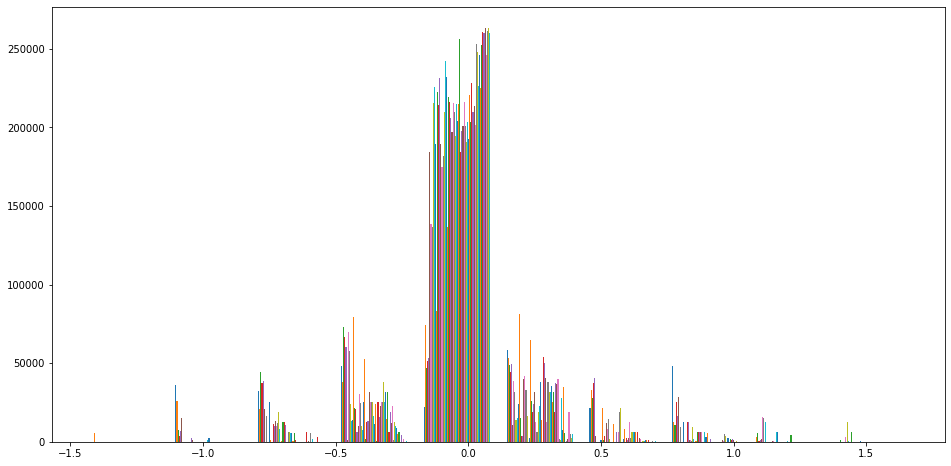

In [6]:
#Pipeline
#Column transformation
# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Column preparation
transformer = [
               ('scaler', MinMaxScaler(feature_range=(0,1)), numerical_cols),
               ('onehot', OneHotEncoder(sparse=False), categorical_cols)]
col_transform = ColumnTransformer(transformers=transformer)

pipeline_x = Pipeline(steps=[('prep', col_transform),
                             ('pca', PCA(n_components=60, random_state=1))])
pipeline_y =  Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0,1)))])

pipeline_x.fit(X)
pipeline_y.fit(y.values.reshape(-1, 1))

joblib.dump(pipeline_x, 'pipeline_x.pkl', compress=1)
joblib.dump(pipeline_y, 'pipeline_y.pkl', compress=1)

with open('pipeline_x.pkl',  'rb') as f_x:
    pipeline_x_loaded = joblib.load(f_x)

with open('pipeline_y.pkl',  'rb') as f_y:
    pipeline_y_loaded = joblib.load(f_y)

X_train_scaled, y_train_scaled = pipeline_x_loaded.transform(X_train), pipeline_y_loaded.transform(y_train.values.reshape((-1,1)))
X_val_scaled, y_val_scaled = pipeline_x_loaded.transform(X_val), pipeline_y_loaded.transform(y_val.values.reshape((-1,1)))

X_train_scaled.astype('float32')
y_train_scaled.astype('float32')

X_val_scaled.astype('float32')
y_val_scaled.astype('float32')

print('Min value: ', round(X_train_scaled.min(),2))
print('Max value: ', round(X_train_scaled.max(),2))
plt.hist(X_train_scaled);
print(X_train_scaled.shape)

Min value:  0.0
Max value:  1.0


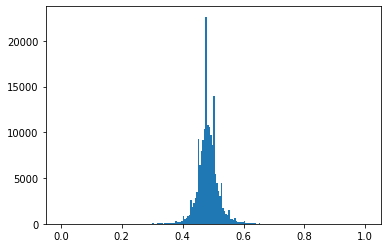

In [16]:
print('Min value: ', round(y_train_scaled.min(),2))
print('Max value: ', round(y_train_scaled.max(),2))
plt.hist(y_train_scaled, bins=200);

#### Split the data into sequences to be used for the model

In [7]:
# Split into sequences
def split_sequences(sequences, n_steps_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_split
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# choose a number of time steps
n_steps_split = 20
# Concat features and target
train_dataset = np.hstack((X_train_scaled, y_train_scaled))
val_dataset = np.hstack((X_val_scaled, y_val_scaled))
# convert into input/output
X_train_split, y_train_split = split_sequences(train_dataset, n_steps_split)
y_train_split = np.reshape(y_train_split, (-1, 1))
X_val_split, y_val_split = split_sequences(val_dataset, n_steps_split)
y_val_split = np.reshape(y_val_split, (-1, 1))

# the dataset knows the number of features, e.g. 2
n_features = X_train_split.shape[2]
n_seq = 4
n_steps = 5
#We can define the ConvLSTM as a single layer in terms of the number of filters
#and a two-dimensional kernel size in terms of (rows, columns).
#As we are working with a one-dimensional series, the number of rows is always
#fixed to 1 in the kernel.
rows = 1

X_train_split = X_train_split.reshape((X_train_split.shape[0], n_seq, rows, n_steps, n_features))
X_val_split = X_val_split.reshape((X_val_split.shape[0], n_seq, rows, n_steps, n_features))

print(X_train_split.shape, y_train_split.shape)

(266468, 4, 1, 5, 60) (266468, 1)


## Build the model

Epoch 1/200
261/261 [==============================] - ETA: 0s - loss: 0.2179 - mae: 0.1190
Epoch 00001: loss improved from inf to 0.21785, saving model to ConvLSTM2D_model.h5
261/261 [==============================] - 30s 117ms/step - loss: 0.2179 - mae: 0.1190 - val_loss: 0.1043 - val_mae: 0.2333
Epoch 2/200
261/261 [==============================] - ETA: 0s - loss: 0.0349 - mae: 0.0419
Epoch 00002: loss improved from 0.21785 to 0.03489, saving model to ConvLSTM2D_model.h5
261/261 [==============================] - 30s 115ms/step - loss: 0.0349 - mae: 0.0419 - val_loss: 0.0243 - val_mae: 0.0662
Epoch 3/200
261/261 [==============================] - ETA: 0s - loss: 0.0150 - mae: 0.0341
Epoch 00003: loss improved from 0.03489 to 0.01505, saving model to ConvLSTM2D_model.h5
261/261 [==============================] - 30s 115ms/step - loss: 0.0150 - mae: 0.0341 - val_loss: 0.0094 - val_mae: 0.0281
Epoch 4/200
261/261 [==============================] - ETA: 0s - loss: 0.0072 - mae: 0.0309


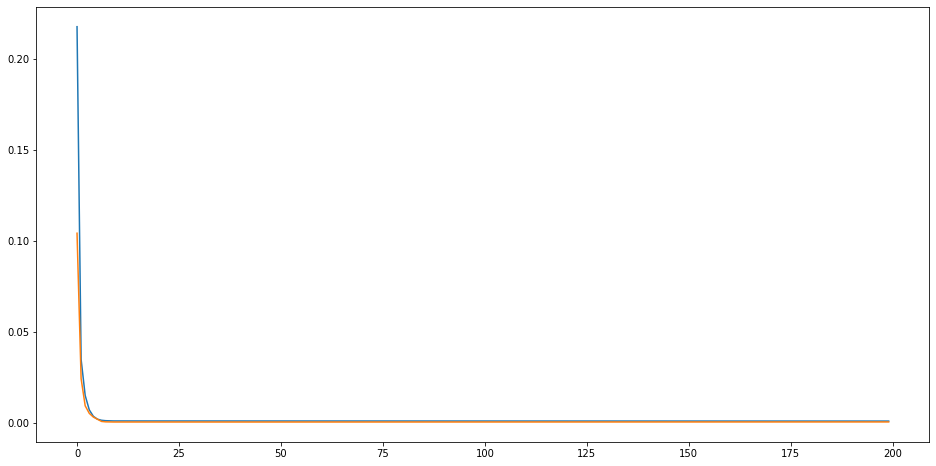

In [8]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=40, kernel_size=(4, 5), activation='relu', input_shape=(n_seq, rows, n_steps, n_features),
                     padding='same', return_sequences=True, go_backwards=True, kernel_regularizer='l2', dropout=0.2))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, kernel_size=(4, 5), activation='relu', input_shape=(n_seq, rows, n_steps, n_features),
                     padding='same', return_sequences=True, go_backwards=True, kernel_regularizer='l2', dropout=0.2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(RepeatVector(1))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Model path
checkpoint_path = 'ConvLSTM2D_model.h5'

## Callbacks:
# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=False,
                              verbose=1, save_best_only=True,
                              monitor='loss')
# Create a callback that prevents the overfitting
early_stopping = EarlyStopping(monitor='loss', mode='auto', verbose=2,
                               patience=10)
# Create a callback to increase the learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=1e-5, mode='min')

# fit model
history = model.fit(X_train_split, y_train_split, epochs=100, batch_size=1024,
                    callbacks=[cp_callback, early_stopping, reduce_lr],
                    validation_data=(X_val_split, y_val_split), shuffle=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Test the model

In [9]:
X_test_scaled = pipeline_x_loaded.transform(X_test)
y_test_scaled = pipeline_y_loaded.transform(y_test.values.reshape((-1,1)))

X_test_scaled.astype('float32')
y_test_scaled.astype('float32')

# Concat features and target
test_dataset = np.hstack((X_test_scaled, y_test_scaled))
# convert into input/output
X_test_split, y_test_split = split_sequences(test_dataset, n_steps_split)
y_test_split = np.reshape(y_test_split, (-1, 1))
# the dataset knows the number of features, e.g. 2
n_features = X_test_split.shape[2]

X_test_split = X_test_split.reshape((X_test_split.shape[0], n_seq, rows, n_steps, n_features))

# Load model
model = load_model('ConvLSTM2D_model.h5')
yhat = model.predict(X_test_split)
yhat = yhat.reshape((-1, 1)) # For TimeDistributed
predicted = pipeline_y_loaded.inverse_transform(yhat)

evaluation = model.evaluate(X_test_split, y_test_split)
print('Model evaluation: ', evaluation)



256/256 [==============================] - 2s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0242
Model evaluation:  [0.0010406547226011753, 0.024244222790002823]


#### Predictions

In [10]:
# Predictions table
df_predicted = pd.DataFrame()
df_predicted['short_result'] = y_test.iloc[n_steps_split -1:]
df_predicted['predictions'] = predicted
#df_predicted = round(df_predicted,1)
print(df_predicted.tail(20))

            short_result  predictions
date                                 
2020-08-03          -8.0     1.161044
2020-08-04         -10.0     1.253905
2020-08-05         -11.0     1.145322
2020-08-06          -9.0     1.096220
2020-08-07          -9.0     1.134565
2020-08-10         -11.0     1.239049
2020-08-11         -13.0     1.201077
2020-08-12         -12.0     1.046481
2020-08-13          -9.0     1.061645
2020-08-14         -10.0     1.166229
2020-08-17          -8.0     1.315403
2020-08-18          -7.0     1.374941
2020-08-19          -7.0     1.366565
2020-08-20          -5.0     1.477423
2020-08-21          -4.0     1.647661
2020-08-24          -6.0     1.806118
2020-08-25          -2.0     1.937590
2020-08-26           1.0     1.981599
2020-08-27           2.0     2.133734
2020-08-28           0.0     2.290211


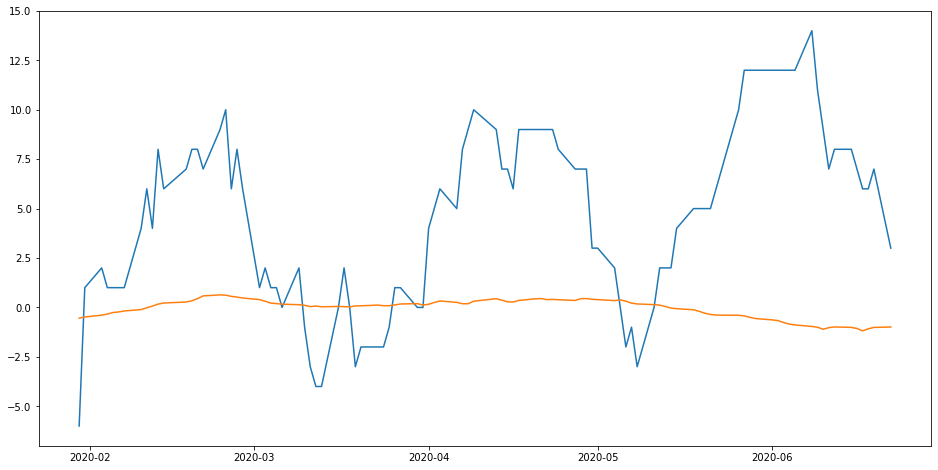

In [14]:
# Plot the predictions
plt.plot(df_predicted.iloc[:100]);

In [12]:
# Analyse the values
df_predicted.describe().T

,count,mean,std,min,25%,50%,75%,max
short_result,8163.0,0.396055,7.473768,-40.000000,-4.000000,0.000000,5.000000,38.000000
predictions,8163.0,0.831301,1.536608,-9.663687,-0.005914,0.830917,1.723635,6.779528


In [13]:
# Metrics
mse = round(mean_squared_error(y_test.iloc[n_steps_split -1:],predicted), 2)
rmse = math.sqrt(mean_squared_error(y_test.iloc[n_steps_split -1:],predicted))
mae = round(mean_absolute_error(y_test.iloc[n_steps_split -1:],predicted), 2)
r2 = round(r2_score(y_test.iloc[n_steps_split -1:],predicted), 2) 
print('mse: ', mse)
print('rmse: ', rmse)
print('mae: ', mae)
print('r2: ', r2)

mse:  58.85
rmse:  7.67125909651661
mae:  5.82
r2:  -0.05
